In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from radioReduction import *
from astropy.stats import LombScargle
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline


In [39]:
# Loading in the data
dt = pd.read_table('2m1315_data_table.txt',sep=' ')

# Splitting up the data
avg = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['Average Flux ($\\mu Jy$)'],'ure':dt['err ($\\mu Jy$)']})
avg = avg[:20]
low = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['5 GHz Flux ($\\mu Jy$)'],'ure':dt['5 GHz err ($\\mu Jy$)']})
low = low[:20]
high = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['7 GHz Flux ($\\mu Jy$)'],'ure':dt['7 GHz err ($\\mu Jy$)']})
high = high[:20]
# Loading the background sources
s1 = pd.read_csv('1315/s1_lc.csv',sep=' ')
s2 = pd.read_csv('1315/s2_lc.csv',sep=' ')
s3 = pd.read_csv('1315/s3_lc.csv',sep=',')

# Putting all the sources into one array
All = pd.merge_asof(s2.sort_values('mjd'),s3.sort_values('mjd'),direction='nearest',on='mjd')
All = pd.merge_asof(All,s1.sort_values('mjd'),direction='nearest',on='mjd')
All = All.drop(columns={'Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0'})

# Filling in missing epochs with 
backGround = All.rename(columns={'re_x':'s2_re', 'ure_x':'s2_ure', 're_y':'s3_re', 'ure_y':'s3_ure', 're':'s1_re','ure':'s1_ure'})

# Stokes V
ll = glob.glob('1315/*-LL.dat')
rr = glob.glob('1315/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

stV = (rr['re']-ll['re'])*0.5
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5

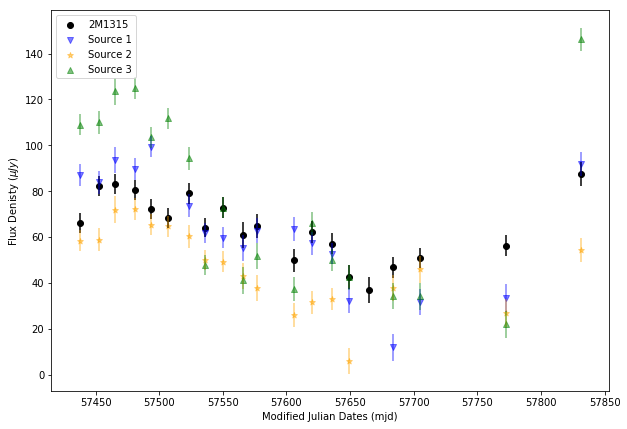

In [8]:
# Plotting the sources
plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')

sources = [s1,s2,s3]
colors = ['blue','orange','green']
markers = ['v','*','^']
j = 0
for i in sources:
    plt.scatter(i['mjd'],i['re'],color=colors[j],marker=markers[j],label='Source %s'%(j+1),alpha=0.5)
    plt.errorbar(i['mjd'],i['re'],color=colors[j],yerr=i['ure'],linestyle='None',label='_nolegend_',alpha=0.5)
    j = j + 1
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Denisty ($\mu Jy$)')
plt.savefig('plots/1315_background.png')
plt.show()

In [9]:
# Creating an average light curves of all the background sources
avgBack = (s1['re']+s2['re']+s3['re'])/3
avgBack[5] = (s2['re'].iloc[5]+s3['re'].iloc[5])/2
avgBackErr = np.sqrt(s1['ure']**2+s2['ure']**2+s3['ure']**2)/3
avgBackErr[5] = np.sqrt(s2['ure'].iloc[5]**2+s3['ure'].iloc[5]**2)/2

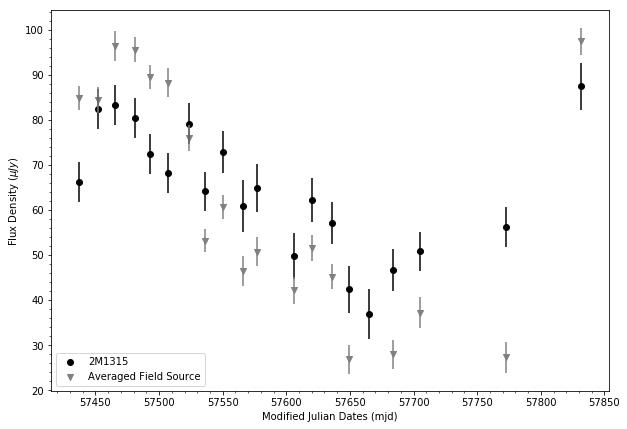

In [10]:
# Plotting the average background light curve
plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')
plt.scatter(s2['mjd'],avgBack,color='gray',marker='v',label='Averaged Field Source')
plt.errorbar(s2['mjd'],avgBack,yerr=avgBackErr,color='gray',linestyle='None',label='_nolabel_')
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.savefig('plots/1315_avgFieldSource.png')
plt.show()

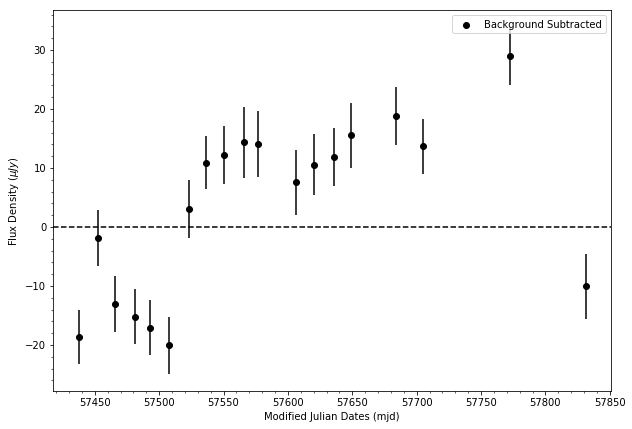

In [71]:
# Subtracting the background light curve and plotting
bgSubbed = avg['re'] - avgBack
bgSubbedErr = np.sqrt(avg['ure']**2+avgBackErr)

plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],bgSubbed,color='k',marker='o',label='Background Subtracted')
plt.errorbar(avg['mjd'],bgSubbed,color='k',yerr=bgSubbedErr,linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.show()


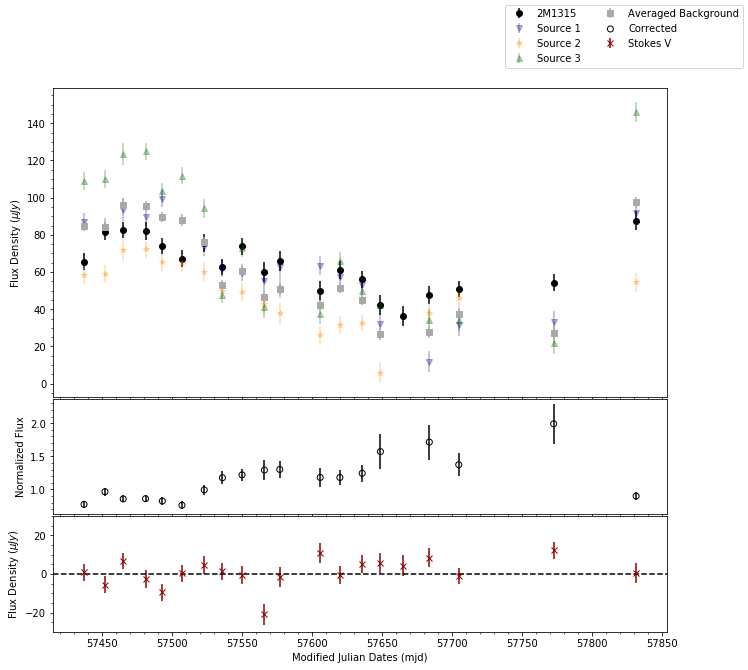

In [194]:
# Calculating ration between 1315 and avg field sources
norm = stI/avgBack
normErr = np.abs(norm)*np.sqrt((stErr/stI)**2+(avgBackErr/avgBack)**2)

# Plotting the sources and the standard deviation
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(11,10),sharex=True,gridspec_kw={'hspace':0.01,'height_ratios':[4,1.5,1.5]})

# Plotting the Sources
sources = [s1,s2,s3]
colors = ['darkblue','darkorange','darkgreen']
markers = ['v','*','^']
legend = []
legend.append(ax[0].errorbar(time,stI,yerr=stErr,color='black',linestyle='none',marker='o',label='2M1315'))
j = 0
for i in sources:
    legend.append(ax[0].errorbar(i['mjd'],i['re'],yerr=i['ure'],color=colors[j],linestyle='None',marker=markers[j],label='Source %s'%(j+1),alpha=0.3))
    j = j + 1
legend.append(ax[0].errorbar(s2['mjd'],avgBack,yerr=avgBackErr,linestyle='None',color='darkgray',marker='s',label='Averaged Background'))
ax[0].set_ylabel('Flux Density ($\mu Jy$)')
ax[0].minorticks_on()


# Plotting background subtracted values
legend.append(ax[1].scatter(avg['mjd'],norm,color='k',marker='o',facecolors='none',edgecolors='black',label='Corrected'))
ax[1].errorbar(avg['mjd'],norm,color='k',yerr=normErr,linestyle='None',label='_nolegend_')
ax[1].minorticks_on()
ax[1].set_ylabel('Normalized Flux')


# Making a plot for stokes V
legend.append(ax[2].errorbar(time,stV,yerr=stErr,color='darkred',marker='x',linestyle='none',label='Stokes V'))
ax[2].axhline(y=0,linestyle='dashed',color='k')
ax[2].set_ylabel('Flux Density ($\mu Jy$)')
ax[2].set_ylim(-30,30)
ax[2].minorticks_on()

# Getting labels for the legend
h,l1 = ax[0].get_legend_handles_labels()
h,l2 = ax[1].get_legend_handles_labels()
h,l3 = ax[2].get_legend_handles_labels()
labels = np.concatenate([l1,l2,l3])

# Creating the legend and labeling axis
fig.legend(legend,labels,loc='upper right',ncol=2)
plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_divided.png')
plt.show()

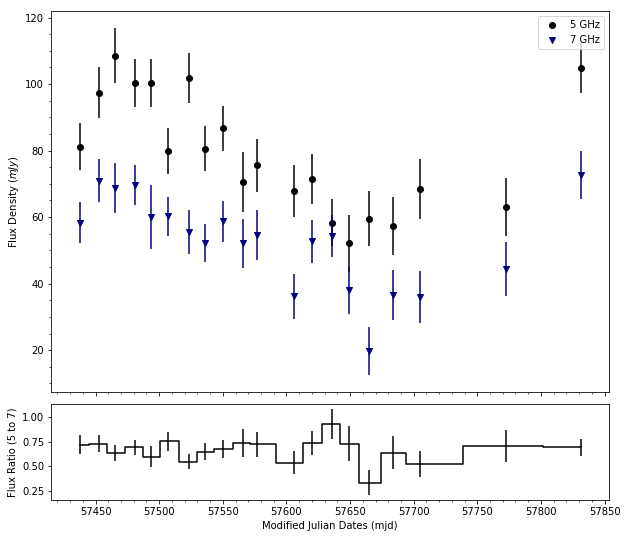

In [30]:
# Calculating Ratio of 5 to 7
ratio = high['re']/low['re']
ratioErr = np.abs(ratio)*np.sqrt((high['ure']/high['re'])**2+(low['ure']/low['re'])**2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,9),gridspec_kw = {'hspace':.05,'height_ratios':[4,1]},sharex=True)
ax[0].scatter(low['mjd'],low['re'],color='k',marker='o',label='5 GHz')
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(high['mjd'],high['re'],color='navy',marker='v',label='7 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',linestyle='None',label='_nolegend_')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].minorticks_on()

ax[1].plot(low['mjd'],ratio,color='black',drawstyle='steps-mid')
ax[1].errorbar(low['mjd'],ratio,color='black',yerr=ratioErr,linestyle='None',label='_nolegend_')
ax[1].set_ylabel('Flux Ratio (5 to 7)')
plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_SED.png')
plt.show()

In [31]:
# Calculating spectral index
alpha = np.log10(ratio)/np.log10(7/5)

# Calculating Error on alpha
errLogR = ratioErr/ratio
alphaErr = np.abs(1/np.log10(7/5))*errLogR

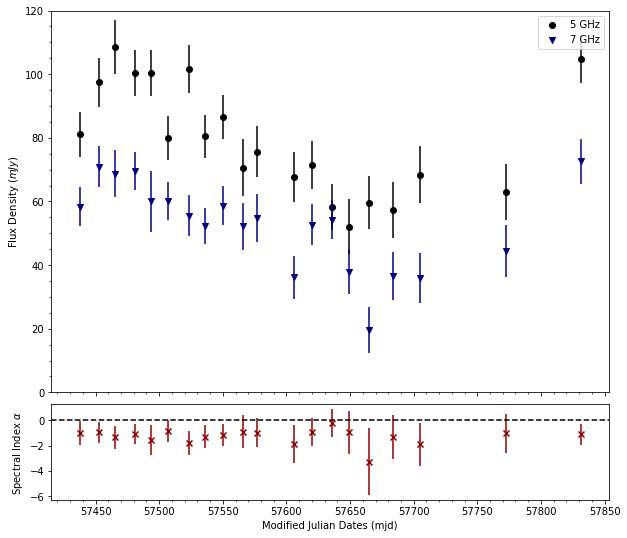

In [37]:
# PLotting alpha values
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,9),gridspec_kw = {'hspace':.05,'height_ratios':[4,1]},sharex=True)
ax[0].scatter(low['mjd'],low['re'],color='k',marker='o',label='5 GHz')
ax[0].errorbar(low['mjd'],low['re'],yerr=low['ure'],color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(high['mjd'],high['re'],color='navy',marker='v',label='7 GHz')
ax[0].errorbar(high['mjd'],high['re'],yerr=high['ure'],color='navy',linestyle='None',label='_nolegend_')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].set_ylim(0,120)
ax[0].minorticks_on()

ax[1].scatter(low['mjd'],alpha,color='darkred',marker='x')
ax[1].errorbar(low['mjd'],alpha,color='darkred',yerr=alphaErr,linestyle='None',label='_nolegend_')
ax[1].set_ylabel('Spectral Index $\\alpha$')
ax[1].axhline(y=0,linestyle='dashed',color='k')

plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_SED_Alpha.png')
plt.show()

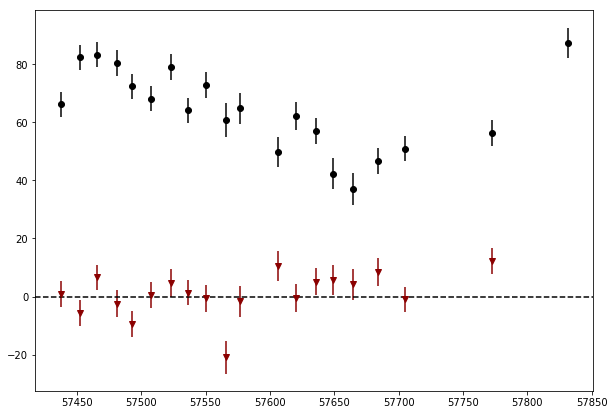

In [45]:
plt.figure(figsize=(10,7))
plt.errorbar(rr['mjd'],stV,yerr=stErr,fmt='v',linestyle='None',color='darkred')
plt.errorbar(avg['mjd'],avg['re'],yerr=avg['ure'],fmt='o',linestyle='None',color='black')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.show()

In [68]:
import datetime
from astropy.time import Time

In [121]:
#x = [12[5[5]]]
time = [datetime.time(2,2,33),
        datetime.time(0,9,11),
        datetime.time(0,21,57),
        datetime.time(22,46,15),
        datetime.time(22,35,19),
        datetime.time(22,30,10),
        datetime.time(20,6,28),
        datetime.time(19,46,14),
        datetime.time(19,47,1),
        datetime.time(18,59,7),
        datetime.time(17,29,56),
        datetime.time(14,11,5),
        datetime.time(15,39,3),
        datetime.time(13,13,7),
        datetime.time(14,21,39),
        datetime.time(12,35,39),
        datetime.time(11,37,1),
        datetime.time(10,59,26),
        datetime.time(5,3,5),
        datetime.time(1,22,52)]

In [107]:
y = avg['re']

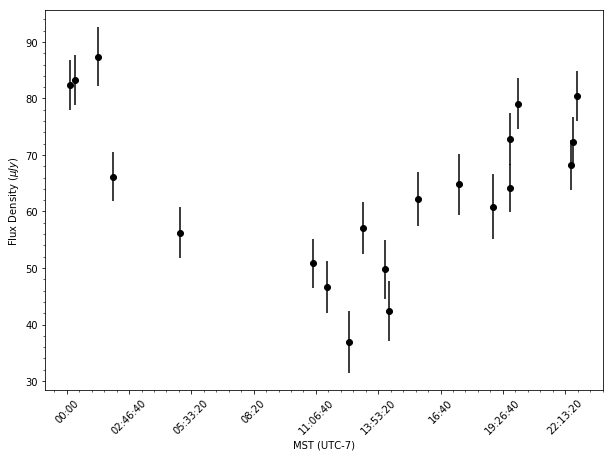

In [157]:
# Plotting data
plt.figure(figsize=(10,7))
plt.errorbar(time,y,yerr=avg['ure'],color='k',marker='o',linestyle='None')

plt.xlabel('MST (UTC-7)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.xticks(rotation=45)
plt.savefig('plots/1315_TimeOfDay.png')
plt.show()

In [167]:
# Stokes V
ll = glob.glob('1315/*-LL.dat')
rr = glob.glob('1315/*-RR.dat')

re = []
ure = []
mjd = []

for i in ll:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
ll = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
ll = ll.sort_values('mjd')
ll = ll.reset_index(drop=True)

re = []
ure = []
mjd = []
for i in rr:
    x = pd.read_table(i)
    m,r,e = meanData(x)
    mjd.append(m)
    re.append(r)
    ure.append(e)
    
rr = pd.DataFrame(data={'mjd':mjd,'re':re,'ure':ure})
rr = rr.sort_values('mjd')
rr = rr.reset_index(drop=True)

In [168]:
# Calculating the stokes V
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['mjd']

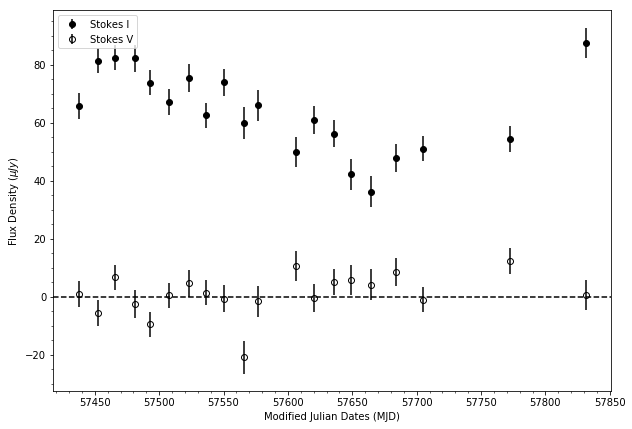

In [171]:
plt.figure(figsize=(10,7))
plt.errorbar(time,stI,yerr=stErr,color='k',marker='o',linestyle='none',label='Stokes I')
plt.errorbar(time,stV,yerr=stErr,color='k',marker='o',markerfacecolor='None',label='Stokes V',linestyle='None')


plt.axhline(y=0,color='k',linestyle='dashed')
plt.minorticks_on()
plt.xlabel('Modified Julian Dates (MJD)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.legend(loc='best')
plt.savefig('plots/1315_Stokes.png')
plt.show()